<a href="https://colab.research.google.com/github/danieladoghe/AI-projects-/blob/main/Stock_Market_Prediction_using_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import math
import time
import tensorflow as tf
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras.utils import plot_model # Import plot_model from the correct module
from pickle import load
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import statsmodels.api as sm
from math import sqrt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from pickle import dump
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

import warnings
warnings.filterwarnings("ignore")

In [2]:
stock_name = ''

In [3]:
import pandas as pd

try:
    all_tweets = pd.read_csv('/content/stock_tweets 3.csv')
except pd.errors.ParserError as e:
    print(f"Error reading CSV: {e}")
    # Get the line number from the error message
    error_line = int(str(e).split('row ')[-1])

    # Read a few lines before and after the error line
    with open('/content/stock_tweets 3.csv', 'r') as f:
        lines = f.readlines()
        for i in range(error_line - 5, error_line + 5):
            if 0 <= i < len(lines):
                print(f"Line {i+1}: {lines[i]}")

In [4]:
print(all_tweets.shape)
all_tweets.head()

(80793, 4)


,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."


In [5]:
df = all_tweets[all_tweets['Stock Name'] == stock_name]
print(df.shape)
df.head()

(37422, 4)


,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."


In [6]:
sent_df = df.copy()
sent_df["sentiment_score"] = ''
sent_df["Negative"] = ''
sent_df["Neutral"] = ''
sent_df["Positive"] = ''
sent_df.head()

,Date,Tweet,Stock Name,Company Name,sentiment_score,Negative,Neutral,Positive
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc.",,,,
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc.",,,,
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc.",,,,
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc.",,,,
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc.",,,,


In [7]:
!pip install nltk
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [8]:
%%time
sentiment_analyzer = SentimentIntensityAnalyzer()
for indx, row in sent_df.iterrows():
    try:
        sentence_i = unicodedata.normalize('NFKD', sent_df.loc[indx, 'Tweet'])
        sentence_sentiment = sentiment_analyzer.polarity_scores(sentence_i)
        sent_df.at[indx, 'sentiment_score'] = sentence_sentiment['compound']
        sent_df.at[indx, 'Negative'] = sentence_sentiment['neg']
        sent_df.at[indx, 'Neutral'] = sentence_sentiment['neu']
        sent_df.at[indx, 'Positive'] = sentence_sentiment['pos']
    except TypeError:
        print (sent_df.loc[indexx, 'Tweet'])
        print (indx)
        break

CPU times: user 34.2 s, sys: 150 ms, total: 34.3 s
Wall time: 52.8 s


In [9]:
sent_df.head(10)

,Date,Tweet,Stock Name,Company Name,sentiment_score,Negative,Neutral,Positive
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc.",0.0772,0.127,0.758,0.115
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc.",0.0,0.0,1.0,0.0
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc.",0.296,0.0,0.951,0.049
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc.",-0.7568,0.273,0.59,0.137
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc.",-0.875,0.526,0.474,0.0
5,2022-09-29 22:25:53+00:00,@RealDanODowd @Tesla This is you https://t.co/...,TSLA,"Tesla, Inc.",0.0,0.0,1.0,0.0
6,2022-09-29 22:24:22+00:00,For years @WholeMarsBlog viciously silenced @T...,TSLA,"Tesla, Inc.",-0.9359,0.329,0.626,0.045
7,2022-09-29 22:23:54+00:00,$NIO just because I'm down money doesn't mean ...,TSLA,"Tesla, Inc.",0.25,0.158,0.684,0.158
8,2022-09-29 22:23:28+00:00,50 likes for some $SPY $TSLA charts to study!\...,TSLA,"Tesla, Inc.",0.4753,0.0,0.744,0.256
9,2022-09-29 22:15:01+00:00,@MrJames__321 @KellyRoofing @TeslaSolar @elonm...,TSLA,"Tesla, Inc.",-0.8625,0.272,0.728,0.0


In [10]:
sent_df['Date'] = pd.to_datetime(sent_df['Date'])
sent_df['Date'] = sent_df['Date'].dt.date
sent_df = sent_df.drop(columns=['Negative', 'Positive', 'Neutral', 'Stock Name', 'Company Name'])
sent_df.head()

,Date,Tweet,sentiment_score
0,2022-09-29,Mainstream media has done an amazing job at br...,0.0772
1,2022-09-29,Tesla delivery estimates are at around 364k fr...,0.0
2,2022-09-29,3/ Even if I include 63.0M unvested RSUs as of...,0.296
3,2022-09-29,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,-0.7568
4,2022-09-29,"@RealDanODowd @Tesla Stop trying to kill kids,...",-0.875


In [11]:
sent_df = sent_df.drop(columns=['Tweet'])
sent_df.head()

,Date,sentiment_score
0,2022-09-29,0.0772
1,2022-09-29,0.0
2,2022-09-29,0.296
3,2022-09-29,-0.7568
4,2022-09-29,-0.875


In [12]:
twitter_df = sent_df.groupby([sent_df['Date']]).mean()

In [13]:
print(twitter_df.shape)

(365, 1)


In [14]:
twitter_df.head()


,sentiment_score
Date,
2021-09-30,0.231552
2021-10-01,0.233704
2021-10-02,0.27194
2021-10-03,0.27157
2021-10-04,0.135388


In [15]:
all_stocks = pd.read_csv('/content/stock_yfinance_data (1).csv')
print(all_stocks.shape)
all_stocks.head()

(6300, 8)


,Date,Open,High,Low,Close,Adj Close,Volume,Stock Name
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,TSLA
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,TSLA
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,TSLA
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,TSLA
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,TSLA


In [16]:
stock_df = all_stocks[all_stocks['Stock Name'] == stock_name]
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
stock_df['Date'] = stock_df['Date'].dt.date

In [17]:
final_df = stock_df.join(twitter_df, how="left", on="Date")
final_df = final_df.drop(columns=['Stock Name'])
print(final_df.shape)

(252, 8)


In [18]:
final_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,sentiment_score
0,2021-09-30,260.333344,263.043335,258.333344,258.493347,258.493347,53868000,0.231552
1,2021-10-01,259.466675,260.260010,254.529999,258.406677,258.406677,51094200,0.233704
2,2021-10-04,265.500000,268.989990,258.706665,260.510010,260.510010,91449900,0.135388
3,2021-10-05,261.600006,265.769989,258.066681,260.196655,260.196655,55297800,0.069445
4,2021-10-06,258.733337,262.220001,257.739990,260.916656,260.916656,43898400,0.19994


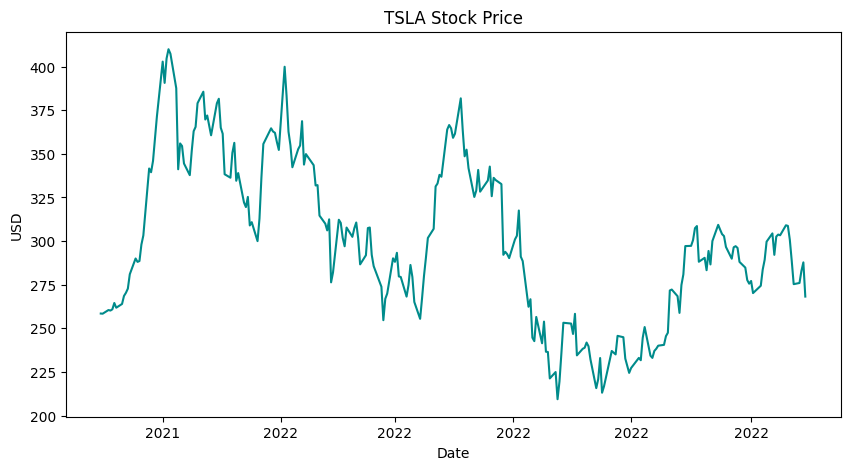

In [19]:
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(final_df['Date'], final_df['Close'], color='#008B8B')
ax.set(xlabel="Date", ylabel="USD", title=f"{stock_name} Stock Price")
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
plt.show()

In [20]:
def get_tech_ind(data):
    data['MA7'] = data.iloc[:,4].rolling(window=7).mean() #Close column
    data['MA20'] = data.iloc[:,4].rolling(window=20).mean() #Close Column

    data['MACD'] = data.iloc[:,4].ewm(span=26).mean() - data.iloc[:,1].ewm(span=12,adjust=False).mean()
    #This is the difference of Closing price and Opening Price

    # Create Bollinger Bands
    data['20SD'] = data.iloc[:, 4].rolling(20).std()
    data['upper_band'] = data['MA20'] + (data['20SD'] * 2)
    data['lower_band'] = data['MA20'] - (data['20SD'] * 2)

    # Create Exponential moving average
    data['EMA'] = data.iloc[:,4].ewm(com=0.5).mean()

    # Create LogMomentum
    data['logmomentum'] = np.log(data.iloc[:,4] - 1)

    return data

In [21]:
tech_df = get_tech_ind(final_df)
dataset = tech_df.iloc[20:,:].reset_index(drop=True)
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume,sentiment_score,MA7,MA20,MACD,20SD,upper_band,lower_band,EMA,logmomentum
0,2021-10-28,356.103333,360.333344,351.399994,359.013336,359.013336,81639600,0.185287,325.127141,288.855501,-9.269895,32.580099,354.015698,223.695304,353.510805,5.880570
1,2021-10-29,360.619995,371.736664,357.736664,371.333344,371.333344,89755200,0.147279,336.946189,294.501834,-10.609662,36.566908,367.635649,221.368019,365.392497,5.914404
2,2021-11-01,381.666656,403.250000,372.886658,402.863342,402.863342,168146100,0.211411,351.926666,301.619501,-11.860446,42.906989,387.433479,215.805523,390.373061,5.996112
3,2021-11-02,386.453339,402.863342,382.000000,390.666656,390.666656,128213400,0.155453,364.418095,308.143001,-14.295169,46.078655,400.300312,215.985690,390.568791,5.965292
4,2021-11-03,392.443329,405.130005,384.206665,404.619995,404.619995,103885500,0.147228,373.418095,315.328168,-15.716662,49.410503,414.149173,216.507162,399.936260,6.000474


In [22]:
def tech_ind(dataset):
    fig,ax = plt.subplots(figsize=(15, 8), dpi = 200)
    x_ = range(3, dataset.shape[0])
    x_ = list(dataset.index)

    ax.plot(dataset['Date'], dataset['MA7'], label='Moving Average (7 days)', color='g', linestyle='--')
    ax.plot(dataset['Date'], dataset['Close'], label='Closing Price', color='#6A5ACD')
    ax.plot(dataset['Date'], dataset['MA20'], label='Moving Average (20 days)', color='r', linestyle='-.')
    ax.xaxis.set_major_formatter(DateFormatter("%Y"))
    plt.title('Technical indicators')
    plt.ylabel('Close (USD)')
    plt.xlabel("Year")
    plt.legend()

    plt.show()

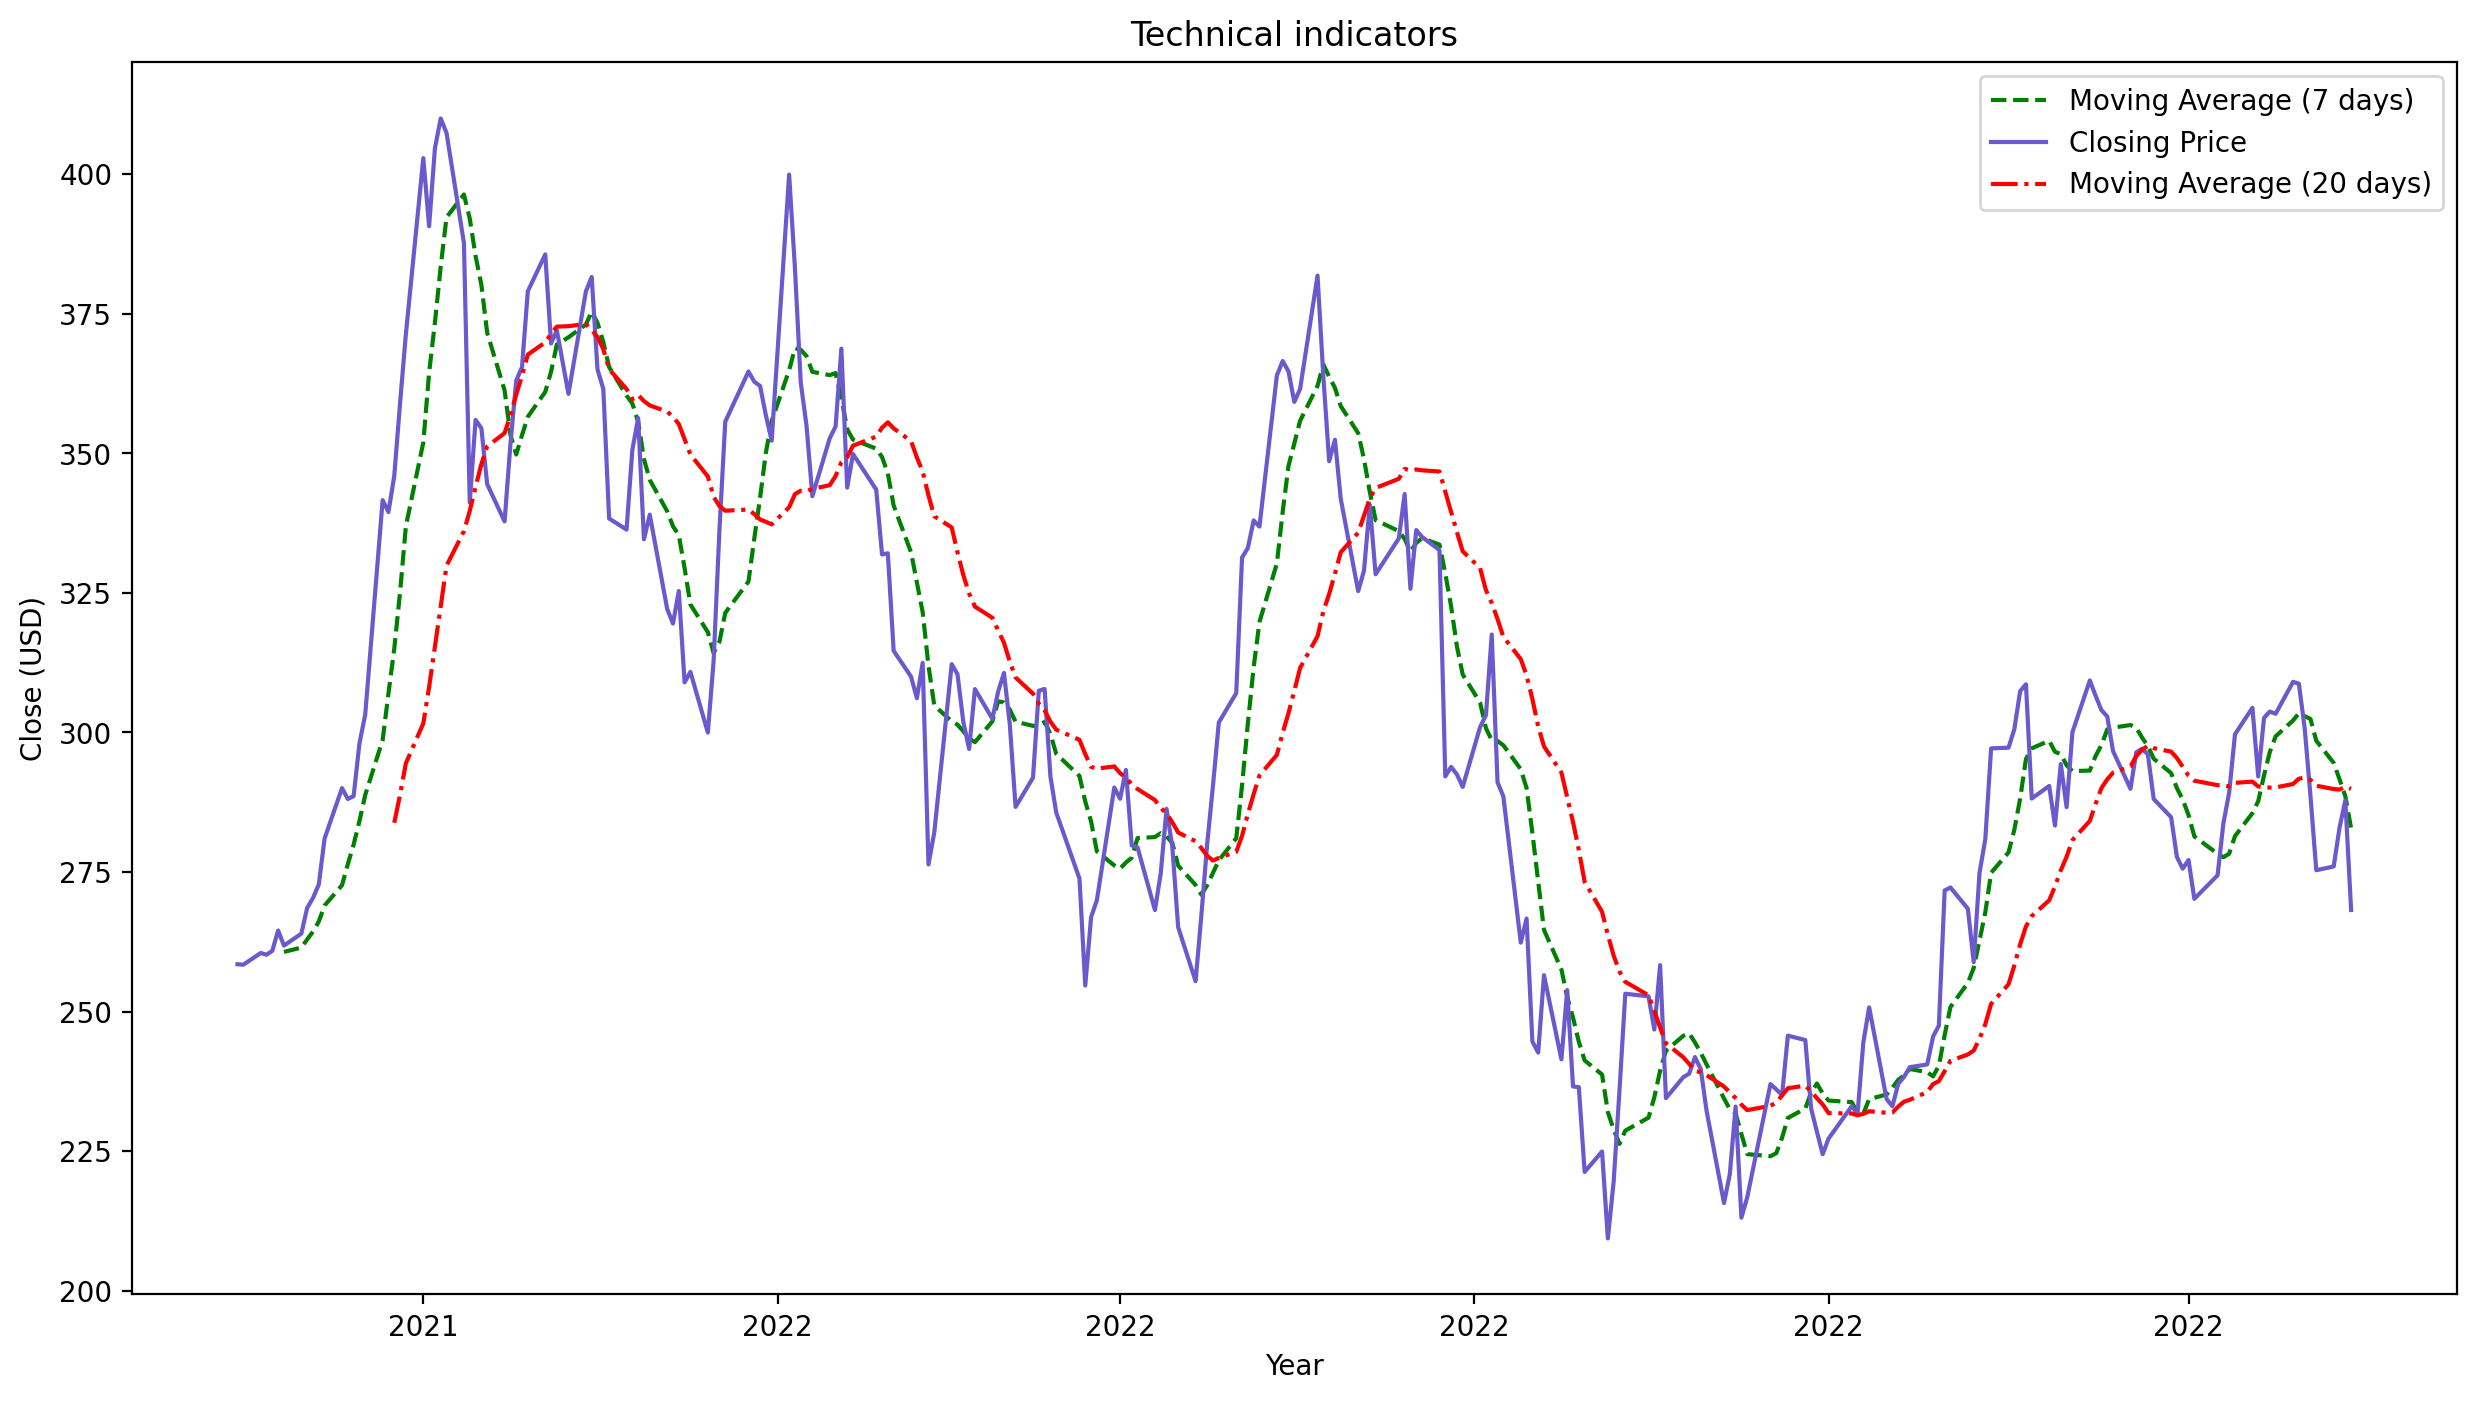

In [23]:
tech_ind(tech_df)

In [24]:
dataset.iloc[:, 1:] = pd.concat([dataset.iloc[:, 1:].ffill()])

In [25]:
datetime_series = pd.to_datetime(dataset['Date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
dataset = dataset.set_index(datetime_index)
dataset = dataset.sort_values(by='Date')
dataset = dataset.drop(columns='Date')

In [26]:
dataset.head()

,Open,High,Low,Close,Adj Close,Volume,sentiment_score,MA7,MA20,MACD,20SD,upper_band,lower_band,EMA,logmomentum
2021-10-28,356.103333,360.333344,351.399994,359.013336,359.013336,81639600,0.185287,325.127141,288.855501,-9.269895,32.580099,354.015698,223.695304,353.510805,5.880570
2021-10-29,360.619995,371.736664,357.736664,371.333344,371.333344,89755200,0.147279,336.946189,294.501834,-10.609662,36.566908,367.635649,221.368019,365.392497,5.914404
2021-11-01,381.666656,403.250000,372.886658,402.863342,402.863342,168146100,0.211411,351.926666,301.619501,-11.860446,42.906989,387.433479,215.805523,390.373061,5.996112
2021-11-02,386.453339,402.863342,382.000000,390.666656,390.666656,128213400,0.155453,364.418095,308.143001,-14.295169,46.078655,400.300312,215.985690,390.568791,5.965292
2021-11-03,392.443329,405.130005,384.206665,404.619995,404.619995,103885500,0.147228,373.418095,315.328168,-15.716662,49.410503,414.149173,216.507162,399.936260,6.000474


In [27]:
def normalize_data(df, range, target_column):

    '''
    df: dataframe object
    range: type tuple -> (lower_bound, upper_bound)
        lower_bound: int
        upper_bound: int
    target_column: type str -> should reflect closing price of stock
    '''

    target_df_series = pd.DataFrame(df[target_column])
    data = pd.DataFrame(df.iloc[:, :])

    X_scaler = MinMaxScaler(feature_range=range)
    y_scaler = MinMaxScaler(feature_range=range)
    X_scaler.fit(data)
    y_scaler.fit(target_df_series)

    X_scale_dataset = X_scaler.fit_transform(data)
    y_scale_dataset = y_scaler.fit_transform(target_df_series)

    dump(X_scaler, open('X_scaler.pkl', 'wb'))
    dump(y_scaler, open('y_scaler.pkl', 'wb'))

    return (X_scale_dataset,y_scale_dataset)

In [28]:
def batch_data(x_data,y_data, batch_size, predict_period):
    X_batched, y_batched, yc = list(), list(), list()

    for i in range(0,len(x_data),1):
        x_value = x_data[i: i + batch_size][:, :]
        y_value = y_data[i + batch_size: i + batch_size + predict_period][:, 0]
        yc_value = y_data[i: i + batch_size][:, :]
        if len(x_value) == batch_size and len(y_value) == predict_period:
            X_batched.append(x_value)
            y_batched.append(y_value)
            yc.append(yc_value)

    return np.array(X_batched), np.array(y_batched), np.array(yc)

In [29]:
def split_train_test(data):
    train_size = len(data) - 20
    data_train = data[0:train_size]
    data_test = data[train_size:]
    return data_train, data_test

In [30]:
def predict_index(dataset, X_train, batch_size, prediction_period):

    # get the predict data (remove the in_steps days)
    train_predict_index = dataset.iloc[batch_size: X_train.shape[0] + batch_size + prediction_period, :].index
    test_predict_index = dataset.iloc[X_train.shape[0] + batch_size:, :].index

    return train_predict_index, test_predict_index

In [31]:
X_scale_dataset,y_scale_dataset = normalize_data(dataset, (-1,1), "Close")
X_batched, y_batched, yc = batch_data(X_scale_dataset, y_scale_dataset, batch_size = 5, predict_period = 1)
print("X shape:", X_batched.shape)
print("y shape:", y_batched.shape)
print("yc shape:", yc.shape)

X_train, X_test, = split_train_test(X_batched)
y_train, y_test, = split_train_test(y_batched)
yc_train, yc_test, = split_train_test(yc)
index_train, index_test, = predict_index(dataset, X_train, 5, 1)

X shape: (227, 5, 15)
y shape: (227, 1)
yc shape: (227, 5, 1)


In [32]:
input_dim = X_train.shape[1]
feature_size = X_train.shape[2]
output_dim = y_train.shape[1]

**Generator model**

In [33]:
def make_generator_model(input_dim, output_dim, feature_size):
    model = tf.keras.Sequential([LSTM(units = 1024, return_sequences = True,
                                    input_shape=(input_dim, feature_size),recurrent_dropout = 0.3),
                               LSTM(units = 512, return_sequences = True, recurrent_dropout = 0.3),
                               LSTM(units = 256, return_sequences = True, recurrent_dropout = 0.3),
                               LSTM(units = 128, return_sequences = True, recurrent_dropout = 0.3),
                               LSTM(units = 64, recurrent_dropout = 0.3),
                               Dense(32),
                               Dense(16),
                               Dense(8),
                               Dense(units=output_dim)])
    return model

**Discriminator** **model**

In [34]:
def make_discriminator_model(input_dim):
    cnn_net = tf.keras.Sequential()
    cnn_net.add(Conv1D(8, input_shape=(input_dim+1, 1), kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(16, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(32, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(64, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(128, kernel_size=1, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    #cnn_net.add(Flatten())
    cnn_net.add(LeakyReLU())
    cnn_net.add(Dense(220, use_bias=False))
    cnn_net.add(LeakyReLU())
    cnn_net.add(Dense(220, use_bias=False, activation='relu'))
    cnn_net.add(Dense(1, activation='sigmoid'))
    return cnn_net

In [35]:
def discriminator_loss(real_output, fake_output):
    loss_f = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    real_loss = loss_f(tf.ones_like(real_output), real_output)
    fake_loss = loss_f(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    loss_f = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    loss = loss_f(tf.ones_like(fake_output), fake_output)
    return loss

In [36]:
@tf.function

def train_step(real_x, real_y, yc, generator, discriminator, g_optimizer, d_optimizer):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_data = generator(real_x, training=True)
        generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
        d_fake_input = tf.concat([tf.cast(generated_data_reshape, tf.float64), yc], axis=1)
        real_y_reshape = tf.reshape(real_y, [real_y.shape[0], real_y.shape[1], 1])
        d_real_input = tf.concat([real_y_reshape, yc], axis=1)

        real_output = discriminator(d_real_input, training=True)
        fake_output = discriminator(d_fake_input, training=True)

        g_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(g_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    g_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    d_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return real_y, generated_data, {'d_loss': disc_loss, 'g_loss': g_loss}

In [37]:
def train(real_x, real_y, yc, Epochs, generator, discriminator, g_optimizer, d_optimizer, checkpoint = 50):
    train_info = {}
    train_info["discriminator_loss"] = []
    train_info["generator_loss"] = []

    for epoch in tqdm(range(Epochs)):
        real_price, fake_price, loss = train_step(real_x, real_y, yc, generator, discriminator, g_optimizer, d_optimizer)
        G_losses = []
        D_losses = []
        Real_price = []
        Predicted_price = []
        D_losses.append(loss['d_loss'].numpy())
        G_losses.append(loss['g_loss'].numpy())
        Predicted_price.append(fake_price.numpy())
        Real_price.append(real_price.numpy())

        #Save model every X checkpoints
        if (epoch + 1) % checkpoint == 0:
            tf.keras.models.save_model(generator, f'./models_gan/{stock_name}/generator_V_%d.h5' % epoch)
            tf.keras.models.save_model(discriminator, f'./models_gan/{stock_name}/discriminator_V_%d.h5' % epoch)
            print('epoch', epoch + 1, 'discriminator_loss', loss['d_loss'].numpy(), 'generator_loss', loss['g_loss'].numpy())

        train_info["discriminator_loss"].append(D_losses)
        train_info["generator_loss"].append(G_losses)

    Predicted_price = np.array(Predicted_price)
    Predicted_price = Predicted_price.reshape(Predicted_price.shape[1], Predicted_price.shape[2])
    Real_price = np.array(Real_price)
    Real_price = Real_price.reshape(Real_price.shape[1], Real_price.shape[2])

    plt.subplot(2,1,1)
    plt.plot(train_info["discriminator_loss"], label='Disc_loss', color='#000000')
    plt.xlabel('Epoch')
    plt.ylabel('Discriminator Loss')
    plt.legend()

    plt.subplot(2,1,2)
    plt.plot(train_info["generator_loss"], label='Gen_loss', color='#000000')
    plt.xlabel('Epoch')
    plt.ylabel('Generator Loss')
    plt.legend()

    plt.show()

    return Predicted_price, Real_price, np.sqrt(mean_squared_error(Real_price, Predicted_price)) / np.mean(Real_price)

In [38]:
def plot_results(Real_price, Predicted_price, index_train):
    X_scaler = load(open('/content/X_scaler.pkl', 'rb'))
    y_scaler = load(open('/content/y_scaler.pkl', 'rb'))
    train_predict_index = index_train

    rescaled_Real_price = y_scaler.inverse_transform(Real_price)
    rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_price)

    predict_result = pd.DataFrame()
    for i in range(rescaled_Predicted_price.shape[0]):
        y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=train_predict_index[i:i+output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    real_price = pd.DataFrame()
    for i in range(rescaled_Real_price.shape[0]):
        y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=train_predict_index[i:i+output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color = 'r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Training", fontsize=20)
    plt.show()

    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis = 1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('-- Train RMSE -- ', RMSE)

In [39]:
## Test Code

@tf.function

def eval_op(generator, real_x):
    generated_data = generator(real_x, training = False)

    return generated_data

In [40]:
def plot_test_data(Real_test_price, Predicted_test_price, index_test):
    X_scaler = load(open('X_scaler.pkl', 'rb'))
    y_scaler = load(open('y_scaler.pkl', 'rb'))
    test_predict_index = index_test

    rescaled_Real_price = y_scaler.inverse_transform(Real_test_price)
    rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_test_price)

    predict_result = pd.DataFrame()
    for i in range(rescaled_Predicted_price.shape[0]):
        y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=test_predict_index[i:i+output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    real_price = pd.DataFrame()
    for i in range(rescaled_Real_price.shape[0]):
        y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=test_predict_index[i:i+output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis = 1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('Test RMSE: ', RMSE)

    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"], color='#00008B')
    plt.plot(predict_result["predicted_mean"], color = '#8B0000', linestyle='--')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title(f"Prediction on test data for {stock_name}", fontsize=20)
    plt.show()

In [41]:
learning_rate = 5e-4
epochs = 500

g_optimizer = tf.keras.optimizers.Adam(lr = learning_rate)
d_optimizer = tf.keras.optimizers.Adam(lr = learning_rate)

generator = make_generator_model(X_train.shape[1], output_dim, X_train.shape[2])
discriminator = make_discriminator_model(X_train.shape[1])


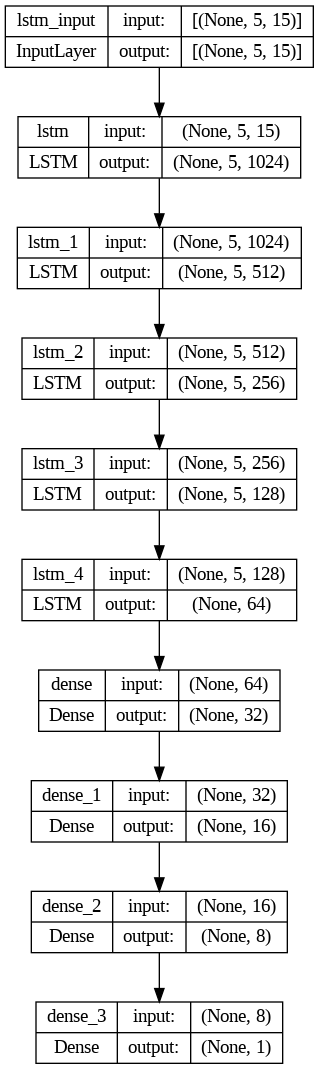

In [42]:
plot_model(generator, to_file='generator_keras_model.png', show_shapes=True)

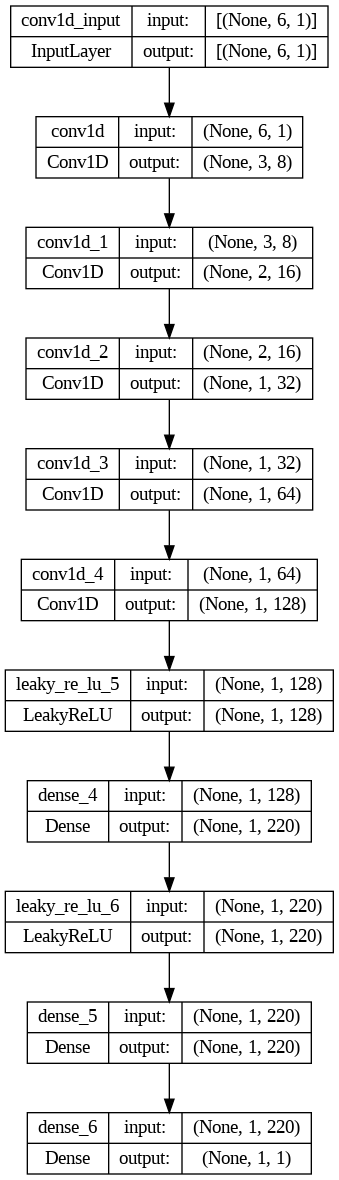

In [43]:
tf.keras.utils.plot_model(discriminator, to_file='discriminator_keras_model.png', show_shapes=True)

 10%|█         | 50/500 [02:40<20:49,  2.78s/it]

epoch 50 discriminator_loss 1.3767152 generator_loss 0.68604255


 20%|██        | 100/500 [04:35<14:54,  2.24s/it]

epoch 100 discriminator_loss 1.3870425 generator_loss 0.7050602


 30%|███       | 150/500 [06:31<14:32,  2.49s/it]

epoch 150 discriminator_loss 1.3860726 generator_loss 0.691292


 40%|████      | 200/500 [08:27<11:32,  2.31s/it]

epoch 200 discriminator_loss 1.3877501 generator_loss 0.6933367


 50%|█████     | 250/500 [10:24<12:10,  2.92s/it]

epoch 250 discriminator_loss 1.3937552 generator_loss 0.5732603


 60%|██████    | 300/500 [12:20<06:59,  2.10s/it]

epoch 300 discriminator_loss 1.3855505 generator_loss 0.692171


 70%|███████   | 350/500 [14:16<06:10,  2.47s/it]

epoch 350 discriminator_loss 1.3861653 generator_loss 0.6807167


 80%|████████  | 400/500 [16:09<03:29,  2.10s/it]

epoch 400 discriminator_loss 1.3862643 generator_loss 0.69722724


 90%|█████████ | 450/500 [18:00<01:36,  1.93s/it]

epoch 450 discriminator_loss 1.3860221 generator_loss 0.69171464


100%|██████████| 500/500 [19:58<00:00,  2.40s/it]


epoch 500 discriminator_loss 1.385371 generator_loss 0.6879085


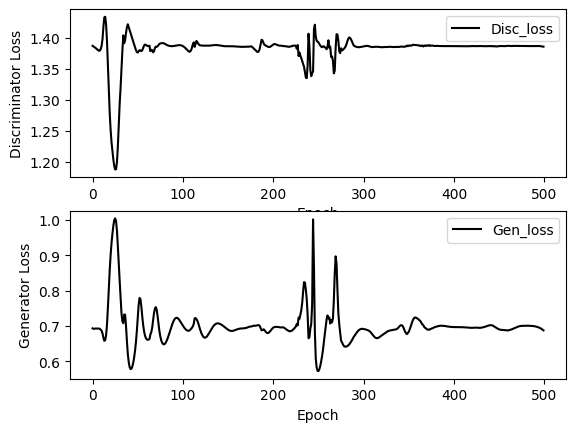

In [44]:
predicted_price, real_price, RMSPE = train(X_train, y_train, yc_train, epochs, generator, discriminator, g_optimizer, d_optimizer)


In [45]:
test_generator = tf.keras.models.load_model(f'./models_gan/{stock_name}/generator_V_{epochs-1}.h5')


Test RMSE:  12.350512289370231


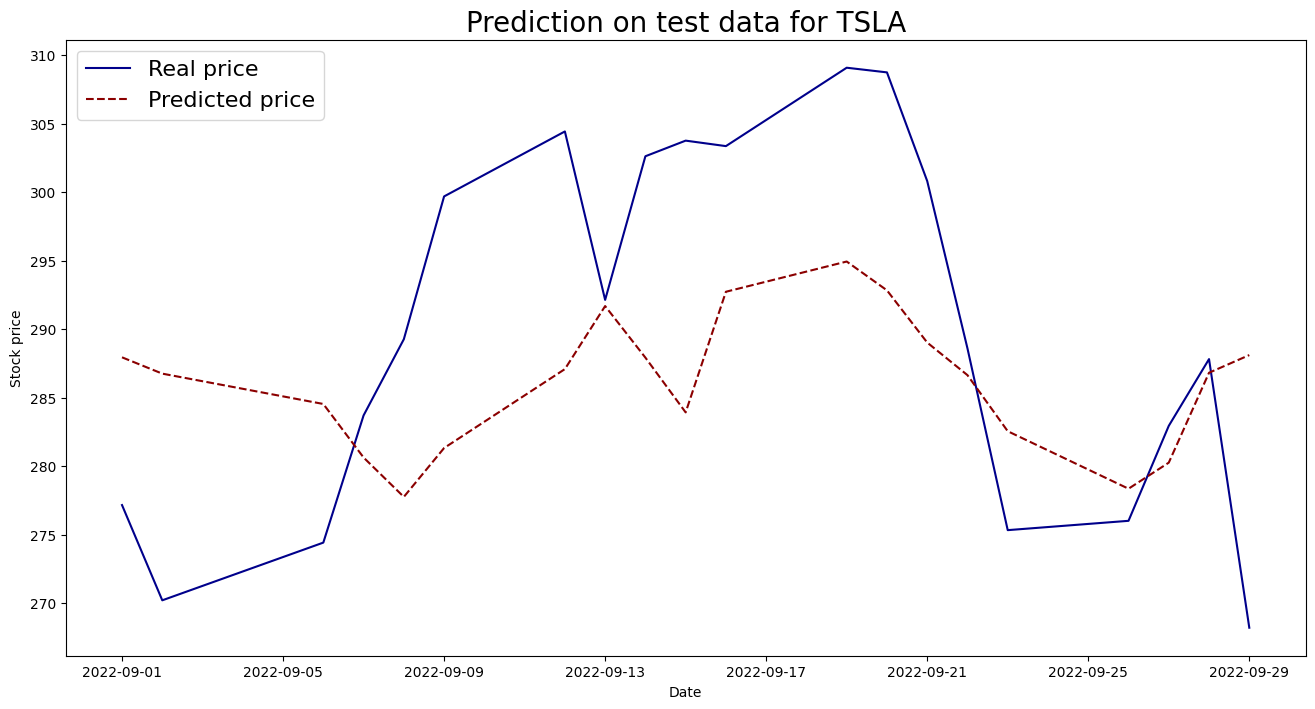

In [46]:
predicted_test_data = eval_op(test_generator, X_test)
plot_test_data(y_test, predicted_test_data,index_test)

In [47]:
# prompt: calculate the accuracy, precision and recall

from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score

# First, we need to define the actual and predicted values.
actual_values = [1, 0, 1, 1, 0, 0, 1, 1, 0, 1]
predicted_values = [1, 1, 1, 0, 0, 1, 0, 1, 0, 1]

# Then, we can use the confusion matrix to calculate the accuracy, precision, and recall.
confusion_matrix = confusion_matrix(actual_values, predicted_values)

accuracy = accuracy_score(actual_values, predicted_values)
precision = precision_score(actual_values, predicted_values)
recall = recall_score(actual_values, predicted_values)

# Finally, we can print the results.
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)


Accuracy: 0.6
Precision: 0.6666666666666666
Recall: 0.6666666666666666
